<a href="https://colab.research.google.com/github/otoperalias/Coyuntura/blob/main/clases/Tema3_IV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Tema 3.4. Introducción a la modelización de series. Modelos ARIMA.

In [2]:
# Instalamos la librería pmdarima (la vamos a necesitar en esta sesión)
!pip install pmdarima --user # Si usamos Jupyter, quitamos el signo de exclamación

# En Colab, debemos instalar la librería cada vez que abrimos sesión. En cambio, si usamos Jupyter notebook solo tenemos que instalarla una vez.

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 21.1 MB/s eta 0:00:00


In [1]:
# Importar la librería recien instalada para ver si está disponible en el entorno de ejecución
# Si da error, reiniciar el entorno de ejecución y volver a importar la librería
import pmdarima as pm

In [3]:
# Importamos funciones y establecemos configuración general
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')

In [ ]:
# Importamos base de datos:

df = pd.read_excel("https://github.com/otoperalias/Coyuntura/raw/main/clases/datos/ventas.xlsx", index_col=0, parse_dates=True)
df

## MODELIZACIÓN DE SERIES.

### 1. Visualización

In [ ]:
# Gráfico serie original
fig,ax=plt.subplots(dpi=75)
ax.plot(df)
ax.set_title('Ventas 1990 - 1998 \n', size=14)
plt.show()

In [ ]:
# Gráfico medias móviles
rol_mean=df.rolling(window=12).mean()
rol_std = df.rolling(window=12).std()

fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(df, color='blue',label='Original')
ax.plot(rol_mean, color='red', label='Media móvil')
ax.plot(rol_std, color='black', label = 'Desv. estándar móvil')
ax.legend(loc='best')
ax.set_title('Media y desv estándar móviles \n', size=14)
ax.spines['bottom'].set_color('black')
plt.show()

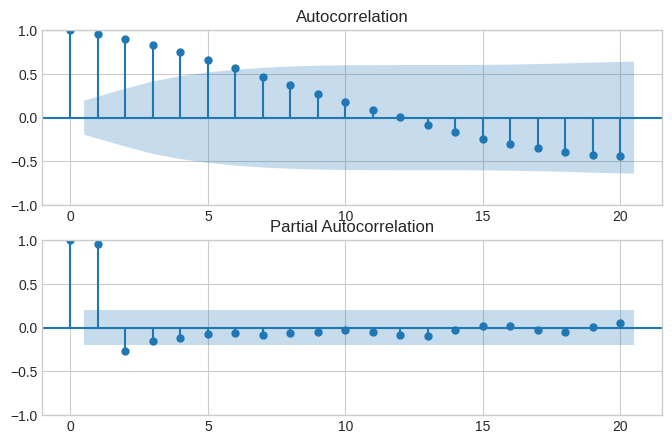

In [11]:
#Correlogramas
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(2, figsize=(8,5))
plot_acf(df.dropna(), ax=ax[0], lags=20)
plot_pacf(df.dropna(), ax=ax[1], lags=20)
plt.show()

### 2. Estacionarizar

#### Tests de Raiz Unitaria

In [15]:
# Augmented Dickey-Fuller Test
from statsmodels.tsa.stattools import adfuller
def DFtest(datos):
    print('Results of Dickey-Fuller Test (H0= NO estac.):')
    dftest = adfuller(datos, autolag='AIC')
    print('Test Statistic', dftest[0])
    print('p-value', dftest[1])
    print('#Lags Used', dftest[2])
    print('# obs', dftest[3])
    for k, v in dftest[4].items():
        print(k,v)
DFtest(df.ventas)

Results of Dickey-Fuller Test (H0= NO estac.):
Test Statistic -2.4642397172033714
p-value 0.12441935447109387
#Lags Used 3
# obs 96
1% -3.5003788874873405
5% -2.8921519665075235
10% -2.5830997960069446


In [ ]:
# KPSS
from statsmodels.tsa.stattools import kpss
def KPSStest(datos):
    print('Results of KPSS Test (H0= Estac.):')
    dftest = kpss((datos), 'ct')
    print("Test statistic = ", dftest[0])
    print("P-value = ", dftest[1])
    print("Critical values :")
    for k, v in dftest[3].items():
        print(k,v)
KPSStest(df.ventas)


#### Estacionarizando

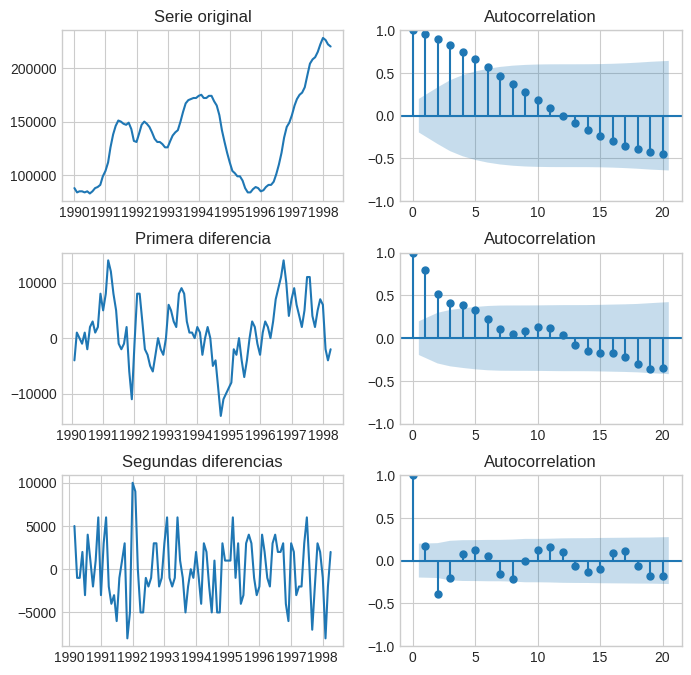

In [17]:
# Es  útil dibujar un gráfico como este, que combine varias transformaciones en una representación
fig, ax = plt.subplots(3, 2, figsize=(8,8))
# Serie original
ax[0,0].plot(df.ventas)
ax[0,0].set_title('Serie original')
plot_acf(df.ventas, ax=ax[0, 1])
# Primera diferencia
ax[1,0].plot(df.ventas.diff())
ax[1,0].set_title('Primera diferencia')
plot_acf(df.ventas.diff().dropna(), ax=ax[1, 1])
# Segunda diferencia
ax[2,0].plot(df.ventas.diff().diff())
ax[2,0].set_title('Segundas diferencias')
plot_acf(df.ventas.diff().diff().dropna(), ax=ax[2, 1])
plt.subplots_adjust(hspace=0.3)
plt.show()

Para estacionarizar, parece conveniente empezar tomando simplemente primeras diferencias ya que los coeficientes de correlación caen rápidamente. Al tomar diferencias de segundo orden, vemos que el segundo retardo tiene un coeficiente negativo elevado, indicando que la serie podría estar sobre-diferenciada (over differencied).

In [ ]:
# Podemos también comprobar que tomando logaritmos no se mejoran los resultados:
fig, ax=plt.subplots(2,1)
ax[0].plot(np.log(df.ventas).diff())
plot_acf(np.log(df.ventas).diff().dropna(),ax=ax[1])
plt.show()

Comprobamos si la serie es estacionaria con el DFtest:

In [19]:
#Comprobamos si la serie es estacionaria con el DFtest
DFtest(df.ventas.diff().dropna())
KPSStest(df.ventas.diff().dropna())

Results of Dickey-Fuller Test (H0= NO estac.):
Test Statistic -2.722238490442952
p-value 0.07026846015272711
#Lags Used 2
# obs 96
1% -3.5003788874873405
5% -2.8921519665075235
10% -2.5830997960069446
Results of KPSS Test (H0= Estac.):
Test statistic =  0.145159656623052
P-value =  0.05155619143879258
Critical values :
10% 0.119
5% 0.146
2.5% 0.176
1% 0.216


Los resultados de los tests nos muestran que está en el límite: estacionariedad débil.  
Por tanto, con las reservas mencionadas, fijamos el orden de diferenciación en uno => d=1.

### 3. Dibujar correlogramas para identificar los parámetros p y q (AR y MA)

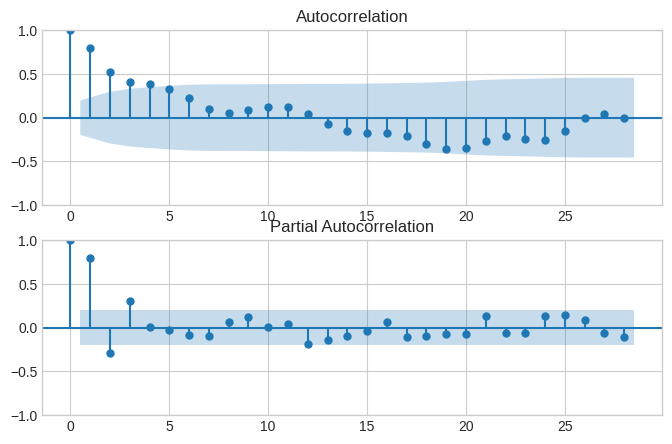

In [21]:
fig, ax = plt.subplots(2,1, figsize=(8,5))
ax[0] = plot_acf(df.ventas.diff().dropna(), ax=ax[0], lags=28)
ax[1] = plot_pacf(df.ventas.diff().dropna(), ax=ax[1], lags=28)
plt.show()

* Componente MA: Vemos en ACF que hay dos retardos bien por encima del nivel de significancia=> q=2.
* Componente AR: El primer retardo el PACF es muy significativo y luego se reduce bastante. Al principio
podemos ser conservadores y establecer p=1.


### 4. Construir el modelo ARIMA

In [22]:
# Implementamos el método ARIMA usando la función SARIMAX, que es más generalizable.
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [23]:
# 1,1,2 ARIMA Model (p,d,q=1,1,2)
model = SARIMAX(df.ventas, order=(1,1,2), trend="c")
model_fit = model.fit()
print(model_fit.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                 ventas   No. Observations:                  100
Model:               SARIMAX(1, 1, 2)   Log Likelihood                -986.053
Date:                Fri, 10 Nov 2023   AIC                           1982.107
Time:                        19:00:14   BIC                           1995.082
Sample:                    01-01-1990   HQIC                          1987.357
                         - 04-01-1998                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    193.9870    331.248      0.586      0.558    -455.247     843.221
ar.L1          0.7558      0.253      2.989      0.003       0.260       1.251
ma.L1         -0.6100      0.255     -2.389      0.0

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Observamos que el coeficiente MA.2 es muy cercano a cero y muy insignificante estadísticamente, por tanto, probamos ahora con ARIMA(1,1,1)

In [25]:
# 1,1,1 ARIMA Model
model_fit = SARIMAX(df.ventas, trend='c', order=(1,1,1)).fit()
print(model_fit.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                 ventas   No. Observations:                  100
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -986.099
Date:                Fri, 10 Nov 2023   AIC                           1980.198
Time:                        19:01:21   BIC                           1990.578
Sample:                    01-01-1990   HQIC                          1984.398
                         - 04-01-1998                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    209.0008    278.474      0.751      0.453    -336.799     754.800
ar.L1          0.7217      0.152      4.747      0.000       0.424       1.020
ma.L1         -0.5850      0.165     -3.537      0.0

* AIC es menor, lo cual es bueno.
* Todos los coeficientes son altamente significativos y con z razonables.
* Ahora representamos los residuos para asegurarnos de que no hay patrones en ellos (o sea, media y varianza constantes)

In [ ]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid[1:])
fig, ax = plt.subplots(2,2,figsize=(12,5))
residuals.plot(title="Residuos", ax=ax[0,0])
residuals.plot(kind='kde', title='Density', ax=ax[1,0])
plot_acf(residuals, ax=ax[0,1], lags=28)
plot_pacf(residuals, ax=ax[1,1], lags=28)
plt.subplots_adjust(hspace=0.5)
plt.show()

Los residuios parecen correctos con media casi cero y varianza uniforme.


## PREDICCIÓN

### 1. Buscando el modelo óptimo: out-of-sample validation

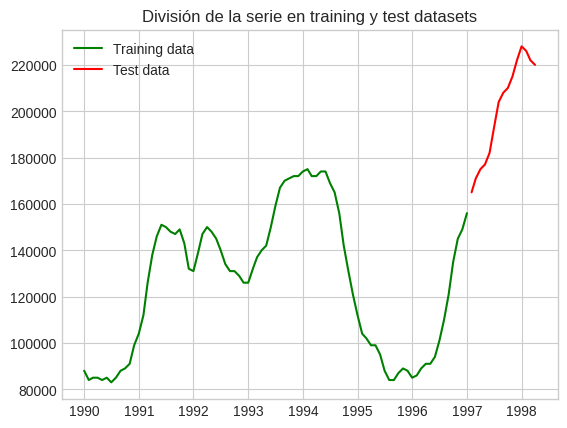

In [40]:

# 1. Creamos training y test datasets
train = df.ventas[:85]
test = df.ventas[85:] # 15% de la base de datos

# Creamos un gráfico para visualizarlo
fig,ax=plt.subplots()
ax.plot(train,c="green",label="Training data")
ax.plot(test,c="red",label="Test data")
ax.set_title("División de la serie en training y test datasets")
ax.legend()
plt.show()

In [28]:
# 2. Construimos el modelo ARIMA(1,1,1)
model_fit = SARIMAX(train, trend='c', order=(1, 1, 1)).fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [42]:
# 3. Predecimos
pred=model_fit.get_prediction(start='1997-02-01',end='1998-04-01')  # (out of sample forecasts , 95% conf)

In [49]:
# 4. Convertimos en series de Pandas
fc_series = pd.Series(pred.predicted_mean, index=test.index)
pred_ci = pred.conf_int(alpha=0.05)
lower_series = pd.Series(pred_ci.iloc[:,0], index=test.index)  # IC inferior [todas filas, primera columna] del array pred_ci
upper_series = pd.Series(pred_ci.iloc[:,1], index=test.index)  # IC superior [todas filas, segunda columna] del array pred_ci

In [ ]:
# 5. Creamos el gráfico
fig, ax= plt.subplots(figsize=(10,5), dpi=80)
ax.plot(train, label='Training dataset')
ax.plot(test, label='Test dataset')
ax.plot(fc_series, label='Predicción')
ax.fill_between(lower_series.index, lower_series, upper_series,color='k', alpha=.15)
ax.set_title('Forecast vs Actuals')
ax.legend(loc='upper left', fontsize=12)
plt.show()

* Observamos que el modelo predice mal.
* Para mejorar el modelo, vamos a probar otras alternativas. Por ej., d=2 e iterativamente incrementar p a 5 y entonces q a 5.
* Los criterios para evaluar los modelos son:  
   a) AIC y significatividad de las variables.  
   b) Ver gráficamente la predicción.  
   c) Comparar las medidas de bondad del ajuste respecto a la test dataset, es decir, cuánto se parece la estimación a la test dataset.


In [ ]:
# Construimos el modelo ARIMA(3,2,1) => tras ir probando, este da buen resultado
model_fit = SARIMAX(train,trend='c', order=(3, 2, 1)).fit()
print(model_fit.summary())

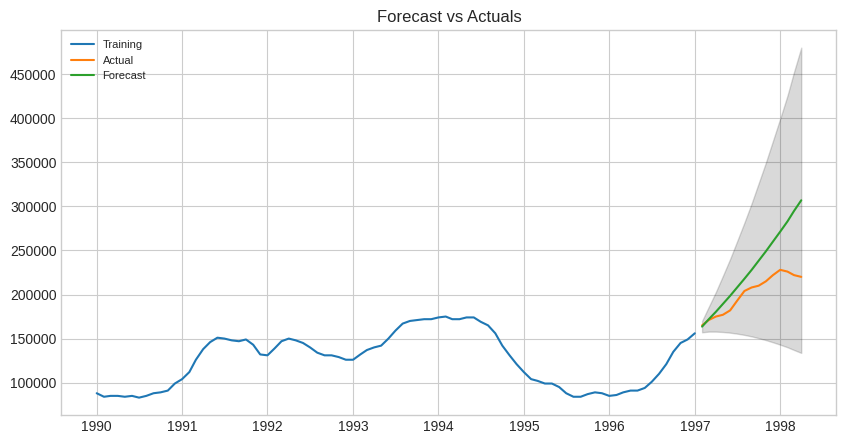

In [54]:
# Predecimos
pred=model_fit.get_prediction(start='1997-02-01',end='1998-04-01')  # (out of sample forecasts )
# Creamos pandas series
fc_series = pd.Series(pred.predicted_mean, index=test.index)
pred_ci = pred.conf_int(alpha=0.05)
lower_series = pd.Series(pred_ci.iloc[:,0], index=test.index)  # IC inferior [todas filas, primer columna] del array conf
upper_series = pd.Series(pred_ci.iloc[:,1], index=test.index)  # IC superior [todas filas, segunda columna] del array conf
# Dibujamos
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train, label='Training')
plt.plot(test, label='Actual')
plt.plot(fc_series, label='Forecast')
plt.fill_between(lower_series.index, lower_series, upper_series,color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

* AIC más bajo, todo significativo y la predicción es mejor.
* En este caso hemos hecho la predicción al final, pero también se puede hacer para otros periodos.
* Lo mejor es testar y elegir el mejor modelo en base a diferentes predicciones.

#### Medidas para juzgar la bondad o exactitud de la predicción.

In [ ]:
def forecast_accuracy(forecast, actual):
    rmse = np.sqrt(np.mean((forecast-actual)**2))
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    return({'rmse':rmse,'mape':mape,'corr':corr})

In [ ]:
forecast_accuracy(fc_series, test)


Un MAPE de 13.8% indica que el modelo tiene una exactitud del 86.2% prediciendo las 15 observaciones siguientes.

#### Construir el modelo óptimo automáticamente

https://pypi.org/project/pmdarima/  
https://www.alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html#pmdarima.arima.auto_arima  
Si usamos un Jupyter notebook en lugar de Google Colab, tenemos que instalar la librería ```pmdarima``` en nuestro PC, pero lo hacemos una sola vez. Para ello, hay que escribir en una celda de código ```pip install pmdarima --user```, si no funciona, hacerlo en cmd ```pip install pmdarima --user```.

In [ ]:
model = pm.auto_arima(train, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0,
                      D=0,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)  # Si True, la función toma "atajos" para terminar antes, pero la soluc. puede ser subóptima.
print(model.summary())

In [ ]:
# Ahora interpretamos los residuos
model.plot_diagnostics(figsize=(7,5))
plt.subplots_adjust(hspace=0.5)
plt.show()

In [ ]:
# Predecimos de nuevo usando este modelo
fc, confint = model.predict(n_periods=15, return_conf_int=True)
index_of_fc = df.index[-15:]
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

In [ ]:
# Gráfico
fig,ax=plt.subplots()
ax.plot(df.ventas)
ax.plot(fc_series, color='darkgreen')
ax.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
ax.set_title("Predicción Final Ventas")
plt.show()

In [ ]:
# Juzgamos la bondad de la predicción
forecast_accuracy(fc, test)

### 2. Predecir "el futuro"

Dado que este último modelo predice mejor, lo usamos para predecir el futuro.

In [ ]:
# ARIMA(0,2,0)
model_fit = SARIMAX(df.ventas,trend='c', order=(0, 2, 0)).fit()
print(model_fit.summary())

In [ ]:
# Predecimos un año
pred=model_fit.get_prediction(start='1998-05-01',end='1999-04-01')
# Creamos pandas series
index_fc=pd.date_range(start="1998-05-01",end="1999-04-01", freq="MS")
fc_series = pd.Series(pred.predicted_mean, index=index_fc)
pred_ci = pred.conf_int(alpha=0.05)
lower_series = pd.Series(pred_ci.iloc[:,0], index=index_fc)  # IC inferior [todas filas, primer columna] del array conf
upper_series = pd.Series(pred_ci.iloc[:,1], index=index_fc)  # IC superior [todas filas, segunda columna] del array conf
# Dibujamos
fig,ax=plt.subplots(figsize=(10,4), dpi=100)
ax.plot(df.ventas, label='Actual')
ax.plot(fc_series, label='Forecast')
ax.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
ax.set_title('Sales forcast')
plt.legend(loc='upper left', fontsize=8)
plt.show()